In [1]:
from datasets.get_datasets import *
from boostedrevision import *
from boostsrl import boostsrl
import random
from sklearn.model_selection import KFold
import numpy as np

## Transfer Learning IMDB -> UW-CSE

In [2]:
source_target = 'workedunder'
validation_size = 0.1
test_size= 0.1
target_size = 1.0
max_revision_iterations = 10
revision_threshold = 0.8

In [3]:
[source_facts, source_pos, source_neg] = get_imdb_dataset(source_target)

source_bk = ['workedunder(+person,+person).',
      'workedunder(+person,-person).',
      'workedunder(-person,+person).',
      'female(+person).',
      'actor(+person).',
      'director(+person).',
      'movie(+movie,+person).',
      'movie(+movie,-person).',
      'movie(-movie,+person).',
      'genre(+person,+genre).']

In [4]:
target_target = 'advisedby'

[target_facts, target_pos, target_neg] = get_uwcse_dataset(target_target, acceptedPredicates=[
'professor',
'student',
'advisedby',
'tempadvisedby',
'ta',
'hasposition',
'publication',
'inphase',
'courselevel',
'yearsinprogram',
'projectmember',
])

target_bk = ['professor(+person).',
'student(+person).',
'advisedby(+person,+person).',
'advisedby(+person,-person).',
'advisedby(-person,+person).',
'tempadvisedby(+person,+person).',
'tempadvisedby(+person,-person).',
'tempadvisedby(-person,+person).',
'ta(+course,+person,+quarter).',
'ta(-course,+person,+quarter).',
'ta(+course,-person,+quarter).',
'ta(+course,+person,-quarter).',
'ta(-course,+person,-quarter).',
'ta(+course,-person,-quarter).',
'hasposition(+person,+faculty).',
'hasposition(+person,-faculty).',
'hasposition(-person,+faculty).',
'publication(+title,+person).',
'publication(+title,-person).',
'publication(-title,+person).',
'inphase(+person,+prequals).',
'inphase(+person,-prequals).',
'inphase(-person,+prequals).',
'courselevel(+course,+level).',
'courselevel(+course,-level).',
'courselevel(-course,+level).',
'yearsinprogram(+person,+year).',
'yearsinprogram(-person,+year).',
'yearsinprogram(+person,-year).',
'projectmember(+project,+person).',
'projectmember(+project,-person).',
'projectmember(-project,+person).']
#'sameproject(project, project).',
#'samecourse(course, course).',
#'sameperson(person, person).',]

In [6]:
background = boostsrl.modes(source_bk, [source_target], useStdLogicVariables=False, maxTreeDepth=12, nodeSize=3, numOfClauses=12)

# shuffle all examples
random.shuffle(source_pos)
random.shuffle(source_neg)
source_neg = source_neg[:len(source_pos)]

# separate train and test
test_pos = source_pos[:int(test_size*len(source_pos))]
test_neg = source_neg[:int(test_size*len(source_neg))]
train_pos = source_pos[int(test_size*len(source_pos)):]
train_neg = source_neg[int(test_size*len(source_neg)):]

train_pos = train_pos[int(validation_size*len(train_pos)):]
train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Train pos size: %s' % len(train_pos))
print('Train neg size: %s' % len(train_neg))
print('Validation pos size: %s' % len(validation_pos))
print('Validation neg size: %s' % len(validation_neg))
print('Test pos size: %s' % len(test_pos))
print('Test neg size: %s' % len(test_neg))

Train pos size: 310
Train neg size: 310
Validation pos size: 31
Validation neg size: 31
Test pos size: 38
Test neg size: 38


## Learning from source domain

In [7]:
[model, total_revision_time, inference_time, t_results, structured, will] = learn_test_model(background, boostsrl, source_target, train_pos, train_neg, source_facts, test_pos, test_neg, refine=None, trees=10, verbose=True)

WILL Produced-Tree #1
% FOR workedunder(A, B):
%   if ( director(B), movie(C, A), movie(C, B) )
%   then if ( female(A) )
%   | then return 0.8581489350995101;  // std dev = 8,68e-07, 143,000 (wgt'ed) examples reached here.  /* #pos=143 */
%   | else return 0.8463146155728823;  // std dev = 0,108, 169,000 (wgt'ed) examples reached here.  /* #neg=2 #pos=167 */
%   else return -0.14185106490048793;  // std dev = 0,000, 308,000 (wgt'ed) examples reached here.  /* #neg=308 */
WILL Produced-Tree #2
% FOR workedunder(A, B):
%   if ( director(B), movie(C, A), movie(C, B) )
%   then return 0.714353580259372;  // std dev = 0,080, 312,000 (wgt'ed) examples reached here.  /* #neg=2 #pos=310 */
%   else return -0.12544463852839194;  // std dev = 0,000, 308,000 (wgt'ed) examples reached here.  /* #neg=308 */
WILL Produced-Tree #3
% FOR workedunder(A, B):
%   if ( director(B), movie(C, A), movie(C, B) )
%   then if ( female(A) )
%   | then return 0.5566303391493649;  // std dev = 4,69e-07, 143,000 (

In [8]:
from boostedtransfer import *

transferred_structured = transfer(structured, ['workedunder(A, B) -> advisedby(A, B)',
            'director(A) -> professor(A)',
            'actor(A) -> student(A)',
            'movie(A, B) -> publication(A, B)',
            'female(A) -> student(A)'
            ])

In [9]:
transferred_structured

[['advisedby(A, B)',
  {'': 'professor(B), publication(C, A), publication(C, B)',
   'true': 'student(A)'},
  {'false': [0.0, 308, 0],
   'true,false': [0.108, 2, 167],
   'true,true': [8.68e-07, 0, 143]}],
 ['advisedby(A, B)',
  {'': 'professor(B), publication(C, A), publication(C, B)'},
  {'false': [0.0, 308, 0], 'true': [0.08, 2, 310]}],
 ['advisedby(A, B)',
  {'': 'professor(B), publication(C, A), publication(C, B)',
   'true': 'student(A)'},
  {'false': [0.0, 308, 0],
   'true,false': [0.108, 2, 167],
   'true,true': [4.69e-07, 0, 143]}],
 ['advisedby(A, B)',
  {'': 'professor(B), publication(C, A), publication(C, B)',
   'true': 'student(A)'},
  {'false': [0.0, 308, 0],
   'true,false': [0.108, 2, 167],
   'true,true': [0.0, 0, 143]}],
 ['advisedby(A, B)',
  {'': 'professor(B), publication(C, A), publication(C, B)',
   'true': 'student(A)'},
  {'false': [1.41e-07, 308, 0],
   'true,false': [0.108, 2, 167],
   'true,true': [2.7e-07, 0, 143]}],
 ['advisedby(A, B)',
  {'': 'professo

## Transfer Learning

In [10]:
background = boostsrl.modes(target_bk, [target_target], useStdLogicVariables=False, maxTreeDepth=12, nodeSize=3, numOfClauses=12)

# shuffle all examples
random.shuffle(target_pos)
random.shuffle(target_neg)
target_pos = target_pos[:int(target_size*len(target_pos))]
target_neg = target_neg[:len(target_pos)]

# separate train and test
test_pos = target_pos[:int(test_size*len(target_pos))]
test_neg = target_neg[:int(test_size*len(target_neg))]
train_pos = target_pos[int(test_size*len(target_pos)):]
train_neg = target_neg[int(test_size*len(target_neg)):]

train_pos = train_pos[int(validation_size*len(train_pos)):]
train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Train pos size: %s' % len(train_pos))
print('Train neg size: %s' % len(train_neg))
print('Validation pos size: %s' % len(validation_pos))
print('Validation neg size: %s' % len(validation_neg))
print('Test pos size: %s' % len(test_pos))
print('Test neg size: %s' % len(test_neg))

Train pos size: 92
Train neg size: 92
Validation pos size: 9
Validation neg size: 9
Test pos size: 11
Test neg size: 11


In [11]:
[model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target_target, train_pos, train_neg, target_facts, validation_pos, validation_neg, test_pos, test_neg, revision_threshold, transferred_structured.copy(), trees=10, max_revision_iterations=10, verbose=True)

******************************************
Performing Parameter Learning
******************************************
Refine
['0;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '0;true;student(A).;false;false', '1;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;false;false', '2;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '2;true;student(A).;false;false', '3;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '3;true;student(A).;false;false', '4;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '4;true;student(A).;false;false', '5;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '5;true;student(A).;false;false', '6;;advisedby(A, B) :- professor(B), publication(C, A), publication(C, B).;true;false', '6;true;student(A).;false;false', '7;;advisedby(A, B) :- professor(B), publication(C, A),

## Results

In [6]:
source_target = 'workedunder'
validation_size = 0.1
test_size= 0.1
target_size = 0.2
max_revision_iterations = 10
revision_threshold = 0.9

[source_facts, source_pos, source_neg] = get_imdb_dataset(source_target)

source_bk = ['workedunder(+person,+person).',
      'workedunder(+person,-person).',
      'workedunder(-person,+person).',
      'female(+person).',
      'actor(+person).',
      'director(+person).',
      'movie(+movie,+person).',
      'movie(+movie,-person).',
      'movie(-movie,+person).',
      'genre(+person,+genre).']

target_target = 'advisedby'

[target_facts, target_pos, target_neg] = get_uwcse_dataset(target_target, acceptedPredicates=[
'professor',
'student',
'advisedby',
'tempadvisedby',
'ta',
'hasposition',
'publication',
'inphase',
'courselevel',
'yearsinprogram',
'projectmember',
])

target_bk = ['professor(+person).',
'student(+person).',
'advisedby(+person,+person).',
'advisedby(+person,-person).',
'advisedby(-person,+person).',
'tempadvisedby(+person,+person).',
'tempadvisedby(+person,-person).',
'tempadvisedby(-person,+person).',
'ta(+course,+person,+quarter).',
'ta(-course,+person,+quarter).',
'ta(+course,-person,+quarter).',
'ta(+course,+person,-quarter).',
'ta(-course,+person,-quarter).',
'ta(+course,-person,-quarter).',
'hasposition(+person,+faculty).',
'hasposition(+person,-faculty).',
'hasposition(-person,+faculty).',
'publication(+title,+person).',
'publication(+title,-person).',
'publication(-title,+person).',
'inphase(+person,+prequals).',
'inphase(+person,-prequals).',
'inphase(-person,+prequals).',
'courselevel(+course,+level).',
'courselevel(+course,-level).',
'courselevel(-course,+level).',
'yearsinprogram(+person,+year).',
'yearsinprogram(-person,+year).',
'yearsinprogram(+person,-year).',
'projectmember(+project,+person).',
'projectmember(+project,-person).',
'projectmember(-project,+person).']
#'sameproject(project, project).',
#'samecourse(course, course).',
#'sameperson(person, person).',]

In [7]:
small_target_dataset_aucroc = []
small_target_dataset_aucpr = []
transfer_dataset_aucroc = {}
transfer_dataset_aucpr = {}

revisions = 6
   
transfer_mapping = {'workedunder': 'advisedby',
                   'actor': 'student',
                   'director': 'professor',
                   'movie': 'publication',
                   'genre': 'hasposition',
                   'female': 'student'}

def transfer(s):
    for key, value in transfer_mapping.items():
        s = s.replace(key, value)
    return s

def transfer_struct(structured):
    transfered_structured = structured.copy()
    for item in transfered_structured:
        item[0] = transfer(item[0])
        for key, value in item[1].items():
            item[1][key] = transfer(value)
    return transfered_structured

In [11]:
import sys
import time

start = time.time()
for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
    transfer_dataset_aucroc[str(revision_threshold)] = []
    transfer_dataset_aucpr[str(revision_threshold)] = []

for fold in range(1, 31):
    # shuffle all examples
    random.shuffle(source_pos)
    random.shuffle(source_neg)
    s_pos = source_pos[:]
    s_neg = source_neg[:len(source_pos)]

    # separate train and test
    s_test_pos = s_pos[:int(test_size*len(s_pos))]
    s_test_neg = s_neg[:int(test_size*len(s_neg))]
    s_train_pos = s_pos[int(test_size*len(s_pos)):]
    s_train_neg = s_neg[int(test_size*len(s_neg)):]

    # shuffle all examples
    random.shuffle(target_pos)
    random.shuffle(target_neg)
    t_pos = target_pos[:int(target_size*len(target_pos))]
    t_neg = target_neg[:len(target_pos)]

    # separate train and test
    t_test_pos = t_pos[:int(test_size*len(t_pos))]
    t_test_neg = t_neg[:int(test_size*len(t_neg))]
    t_train_pos = t_pos[int(test_size*len(t_pos)):]
    t_train_neg = t_neg[int(test_size*len(t_neg)):]

    t_train_pos = t_train_pos[int(validation_size*len(t_train_pos)):]
    t_train_neg = t_train_neg[int(validation_size*len(t_train_neg)):]
    validation_pos = t_train_pos[:int(validation_size*len(t_train_pos))]
    validation_neg = t_train_neg[:int(validation_size*len(t_train_neg))]

    # Learning from source
    background = boostsrl.modes(source_bk, [source_target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)
    [model, total_revision_time, inference_time, t_results, target_structured, will] = learn_test_model(background, boostsrl, source_target, s_train_pos, s_train_neg, source_facts, s_test_pos, s_test_neg, refine=None, trees=10, verbose=False)

    sys.stdout.write('\rFold: %s, %s, time: %s' % (fold, 'learning from source', time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
    sys.stdout.flush()

    # Learning from scratch
    background = boostsrl.modes(target_bk, [target_target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)
    [model, total_revision_time, inference_time, t_results, structured, will] = learn_test_model(background, boostsrl, target_target, t_train_pos, t_train_neg, target_facts, t_test_pos, t_test_neg, refine=None, trees=10, verbose=False)
    small_target_dataset_aucroc.append(t_results['AUC ROC'])
    small_target_dataset_aucpr.append(t_results['AUC PR'])

    sys.stdout.write('\rFold: %s, %s, time: %s' % (fold, 'learning from scratch target', time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
    sys.stdout.flush()

    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        # Transfer
        structured = transfer_struct(target_structured)

        # Transfer Learning and Revision Theory
        try:
            [model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target_target, t_train_pos, t_train_neg, target_facts, validation_pos, validation_neg, t_test_pos, t_test_neg, revision_threshold, structured.copy(), max_revision_iterations=10, trees=10, verbose=False)
            transfer_dataset_aucroc[str(revision_threshold)].append(t_results['AUC ROC'])
            transfer_dataset_aucpr[str(revision_threshold)].append(t_results['AUC PR'])

            sys.stdout.write('\rFold: %s, revision_threshold: %s, %s, time: %s' % (fold, revision_threshold, 'transfer learning', time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
            sys.stdout.flush()
        except:
            pass
        

Fold: 30, revision_threshold: 1.0, transfer learning, time: 00:47:25

In [15]:
small_target_dataset_aucroc

[0.931818,
 0.931818,
 1.0,
 0.886364,
 0.954545,
 0.909091,
 0.863636,
 0.931818,
 0.931818,
 1.0,
 0.863636,
 1.0,
 1.0,
 0.909091,
 0.931818,
 1.0,
 1.0,
 1.0,
 0.931818,
 0.954545,
 0.840909,
 0.909091,
 0.863636,
 0.931818,
 1.0,
 0.909091,
 0.931818,
 0.909091,
 1.0,
 0.954545,
 0.931818]

In [16]:
transfer_dataset_aucroc

{'0.5': [0.659091,
  0.909091,
  0.5,
  0.977273,
  0.5,
  0.931818,
  0.75,
  1.0,
  0.545455,
  0.75,
  0.772727,
  0.5,
  0.75,
  0.977273,
  0.545455,
  0.977273,
  0.5,
  0.75,
  0.5,
  0.5,
  0.909091,
  0.954545],
 '0.6': [0.659091,
  0.909091,
  0.5,
  0.5,
  0.931818,
  0.75,
  1.0,
  0.545455,
  0.75,
  0.772727,
  0.5,
  0.75,
  1.0,
  0.545455,
  0.977273,
  0.5,
  0.75,
  0.5,
  0.5,
  0.75,
  0.727273],
 '0.7': [0.659091,
  1.0,
  0.5,
  0.954545,
  0.5,
  0.931818,
  1.0,
  1.0,
  0.954545,
  0.75,
  1.0,
  0.5,
  0.75,
  0.954545,
  0.545455,
  0.977273,
  0.5,
  0.75,
  0.5,
  0.931818,
  0.909091,
  0.954545],
 '0.8': [0.659091,
  0.909091,
  0.863636,
  0.931818,
  1.0,
  0.931818,
  0.886364,
  0.954545,
  0.931818,
  1.0,
  1.0,
  0.954545,
  0.75,
  1.0,
  1.0,
  0.977273,
  0.931818,
  1.0,
  0.954545,
  0.931818,
  0.909091,
  0.954545],
 '0.9': [0.659091,
  0.909091,
  0.818182,
  0.954545,
  1.0,
  0.931818,
  0.954545,
  0.954545,
  0.863636,
  1.0,
  1.0,
  

/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


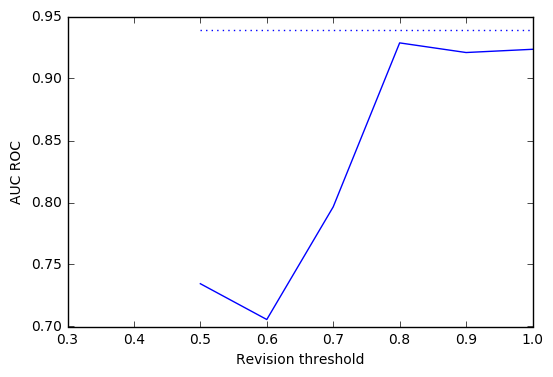

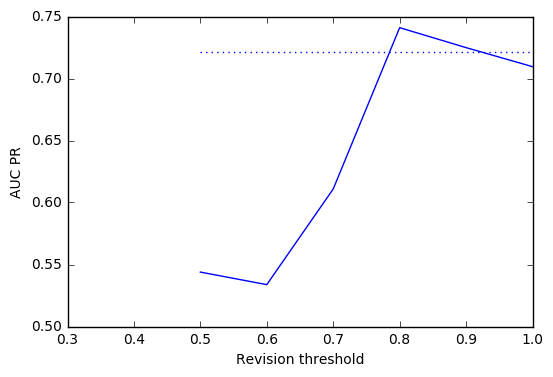

In [17]:
import matplotlib.pyplot as plt
x = []
y = []
base = np.array(small_target_dataset_aucroc)
base = base.mean()
base = revisions * [base]
for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
    x.append(revision_threshold)
    v = transfer_dataset_aucroc[str(revision_threshold)]
    v = np.array(v)
    y.append(v.mean())
plt.plot(x, y, color='blue')
plt.plot(x, base, linestyle=':', color='blue')
plt.xlim(0.3,1.0)
plt.xlabel('Revision threshold')
plt.ylabel('AUC ROC')
plt.legend(loc='upper left')
plt.show()

x = []
y = []
base = np.array(small_target_dataset_aucpr)
base = base.mean()
base = revisions * [base]
for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
    x.append(revision_threshold)
    v = transfer_dataset_aucpr[str(revision_threshold)]
    v = np.array(v)
    y.append(v.mean())
plt.plot(x, y, color='blue')
plt.plot(x, base, linestyle=':', color='blue')
plt.xlim(0.3,1.0)
plt.xlabel('Revision threshold')
plt.ylabel('AUC PR')
plt.legend(loc='upper left')
plt.show()

## Transfer Learning UW-CSE -> IMDB

In [12]:
source_target = 'advisedby'
validation_size = 0.1
test_size= 0.1
target_size = 1.0
max_revision_iterations = 10
revision_threshold = 0.8

In [13]:
source_target = 'advisedby'

[source_facts, source_pos, source_neg] = get_uwcse_dataset(source_target, acceptedPredicates=[
'professor',
'student',
'advisedby',
'tempadvisedby',
'ta',
'hasposition',
'publication',
'inphase',
'courselevel',
'yearsinprogram',
'projectmember',
])

source_bk = ['professor(+person).',
'student(+person).',
'advisedby(+person,+person).',
'advisedby(+person,-person).',
'advisedby(-person,+person).',
'tempadvisedby(+person,+person).',
'tempadvisedby(+person,-person).',
'tempadvisedby(-person,+person).',
'ta(+course,+person,+quarter).',
'ta(-course,+person,+quarter).',
'ta(+course,-person,+quarter).',
'ta(+course,+person,-quarter).',
'ta(-course,+person,-quarter).',
'ta(+course,-person,-quarter).',
'hasposition(+person,+faculty).',
'hasposition(+person,-faculty).',
'hasposition(-person,+faculty).',
'publication(+title,+person).',
'publication(+title,-person).',
'publication(-title,+person).',
'inphase(+person,+prequals).',
'inphase(+person,-prequals).',
'inphase(-person,+prequals).',
'courselevel(+course,+level).',
'courselevel(+course,-level).',
'courselevel(-course,+level).',
'yearsinprogram(+person,+year).',
'yearsinprogram(-person,+year).',
'yearsinprogram(+person,-year).',
'projectmember(+project,+person).',
'projectmember(+project,-person).',
'projectmember(-project,+person).']
#'sameproject(project, project).',
#'samecourse(course, course).',
#'sameperson(person, person).',]

In [14]:
target_target = 'workedunder'
[target_facts, target_pos, target_neg] = get_imdb_dataset(target_target)

target_bk = ['workedunder(+person,+person).',
      'workedunder(+person,-person).',
      'workedunder(-person,+person).',
      'female(+person).',
      'actor(+person).',
      'director(+person).',
      'movie(+movie,+person).',
      'movie(+movie,-person).',
      'movie(-movie,+person).',
      'genre(+person,+genre).']

In [15]:
background = boostsrl.modes(source_bk, [source_target], useStdLogicVariables=False, maxTreeDepth=12, nodeSize=3, numOfClauses=12)

# shuffle all examples
random.shuffle(source_pos)
random.shuffle(source_neg)
source_neg = source_neg[:len(source_pos)]

# separate train and test
test_pos = source_pos[:int(test_size*len(source_pos))]
test_neg = source_neg[:int(test_size*len(source_neg))]
train_pos = source_pos[int(test_size*len(source_pos)):]
train_neg = source_neg[int(test_size*len(source_neg)):]

train_pos = train_pos[int(validation_size*len(train_pos)):]
train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Train pos size: %s' % len(train_pos))
print('Train neg size: %s' % len(train_neg))
print('Validation pos size: %s' % len(validation_pos))
print('Validation neg size: %s' % len(validation_neg))
print('Test pos size: %s' % len(test_pos))
print('Test neg size: %s' % len(test_neg))

Train pos size: 92
Train neg size: 92
Validation pos size: 9
Validation neg size: 9
Test pos size: 11
Test neg size: 11


## Learning from source domain

In [16]:
[model, total_revision_time, inference_time, t_results, structured, will] = learn_test_model(background, boostsrl, source_target, train_pos[:int(0.25*len(train_pos))], train_neg[:int(0.25*len(train_neg))], source_facts, test_pos, test_neg, refine=None, trees=10, verbose=True)

WILL Produced-Tree #1
% FOR advisedby(A, B):
%   if ( professor(B) )
%   then if ( tempadvisedby(C, B) )
%   | then if ( publication(D, C), publication(D, B) )
%   | | then return 0.5248156017661788;  // std dev = 0,816, 3,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=2 */
%   | | else return 0.8581489350995123;  // std dev = 0,000, 13,000 (wgt'ed) examples reached here.  /* #pos=13 */
%   | else if ( ta(E, A, F), publication(G, A) )
%   | | then return -0.14185106490048777;  // std dev = 0,000, 3,000 (wgt'ed) examples reached here.  /* #neg=3 */
%   | | else if ( publication(H, A) )
%   | | | then return 0.8581489350995122;  // std dev = 0,000, 5,000 (wgt'ed) examples reached here.  /* #pos=5 */
%   | | | else return 0.4581489350995122;  // std dev = 1,095, 5,000 (wgt'ed) examples reached here.  /* #neg=2 #pos=3 */
%   else return -0.1418510649004878;  // std dev = 0,000, 17,000 (wgt'ed) examples reached here.  /* #neg=17 */
WILL Produced-Tree #2
% FOR advisedby(A, B):
%   if ( 

In [17]:
transferred_structured = transfer(structured, ['professor(A) -> director(A)',
            'student(A) -> actor(A)',
            'advisedby(A, B) -> workedunder(A, B)',
            'publication(A, B) -> movie(A, B)',
            'hasposition(A, B) -> gender(A, B)'
            ])

In [19]:
transferred_structured

[['workedunder(A, B)',
  {'': 'director(B)',
   'true,false,false': 'movie(H, A)',
   'true,true': 'movie(D, C), movie(D, B)'},
  {'false': [0.0, 17, 0],
   'true,false,false,false': [1.095, 2, 3],
   'true,false,false,true': [0.0, 0, 5],
   'true,false,true': [0.0, 3, 0],
   'true,true,false': [0.0, 0, 13],
   'true,true,true': [0.816, 1, 2]}],
 ['workedunder(A, B)',
  {'': 'director(B)', 'true,false,false': 'movie(L, A)'},
  {'false': [0.0, 17, 0],
   'true,false,false,false': [1.095, 2, 3],
   'true,false,false,true': [0.0, 0, 5],
   'true,false,true': [0.0, 3, 0],
   'true,true,false': [0.08, 0, 12],
   'true,true,true': [0.812, 1, 3]}],
 ['workedunder(A, B)',
  {'': 'director(B)',
   'true,false,false': 'movie(H, A)',
   'true,true': 'movie(D, C), movie(D, B)'},
  {'false': [1.49e-08, 17, 0],
   'true,false,false,false': [1.095, 2, 3],
   'true,false,false,true': [0.0, 0, 5],
   'true,false,true': [2.63e-09, 3, 0],
   'true,true,false': [0.09, 0, 13],
   'true,true,true': [0.772, 

## Transfer Learning

In [20]:
background = boostsrl.modes(target_bk, [target_target], useStdLogicVariables=False, maxTreeDepth=12, nodeSize=3, numOfClauses=12)

# shuffle all examples
random.shuffle(target_pos)
random.shuffle(target_neg)
target_pos = target_pos[:int(target_size*len(target_pos))]
target_neg = target_neg[:len(target_pos)]

# separate train and test
test_pos = target_pos[:int(test_size*len(target_pos))]
test_neg = target_neg[:int(test_size*len(target_neg))]
train_pos = target_pos[int(test_size*len(target_pos)):]
train_neg = target_neg[int(test_size*len(target_neg)):]

train_pos = train_pos[int(validation_size*len(train_pos)):]
train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Train pos size: %s' % len(train_pos))
print('Train neg size: %s' % len(train_neg))
print('Validation pos size: %s' % len(validation_pos))
print('Validation neg size: %s' % len(validation_neg))
print('Test pos size: %s' % len(test_pos))
print('Test neg size: %s' % len(test_neg))

Train pos size: 310
Train neg size: 310
Validation pos size: 31
Validation neg size: 31
Test pos size: 38
Test neg size: 38


In [21]:
[model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target_target, train_pos, train_neg, target_facts, validation_pos, validation_neg, test_pos, test_neg, revision_threshold, transferred_structured.copy(), trees=10, max_revision_iterations=10, verbose=True)

******************************************
Performing Parameter Learning
******************************************
Refine
['0;;workedunder(A, B) :- director(B).;false;false', '0;true,true;movie(D, C), movie(D, B).;false;false', '0;true,false,false;movie(H, A).;false;false', '1;;workedunder(A, B) :- director(B).;false;false', '1;true,false,false;movie(L, A).;false;false', '2;;workedunder(A, B) :- director(B).;false;false', '2;true,true;movie(D, C), movie(D, B).;false;false', '2;true,false,false;movie(H, A).;false;false', '3;;workedunder(A, B) :- director(B).;true;false', '3;true,true;movie(E, B).;false;false', '3;true;movie(E, A).;true;false', '3;true,false,true;movie(G, F).;false;false', '3;true,false,false;movie(H, A).;false;false', '4;;workedunder(A, B) :- director(B).;false;false', '4;true,false,false;movie(L, A).;false;false', '5;;workedunder(A, B) :- gender(B, C), gender(D, C).;true;true', '5;true;movie(I, H).;true;false', '5;false;movie(N, B), movie(N, P).;false;true', '5;true,t